In [1]:
import json
import os
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer, CrossEncoder
from tqdm import tqdm
from scipy.stats import spearmanr
%matplotlib inline

In [2]:
candidate_folders = list_subfolders_with_paths = [f.path for f in os.scandir("raw_data/en_submissions_rdf2text") if f.is_dir()]

In [3]:
human_scores = json.load(open("raw_data/english_humeval_data_all_teams.json"))

In [4]:
teams = set([item["submission_id"] for item in human_scores])
human_scores_per_team = {team: [] for team in teams}
for item in human_scores:
    human_scores_per_team[item["submission_id"]].append(item)

In [5]:
# the last line is inconsistent, let's just fix this
rdfs = open(os.path.join("raw_data", "unwrapped_rdfs.txt")).readlines()[:1779]
ticks = ["correctness", "data coverage", "relevance", "fluency", "text structure", "bert precision",
        "bert recall", "bert F1", "bleurt", "bleu"]

data_2020 = {tick: [] for tick in ticks}

for candidate_folder in tqdm(candidate_folders):
    team = candidate_folder.split("/")[-1]
    print(team)
    all_auto_scores = json.load(open(os.path.join(candidate_folder, "primary.en_results")))
    all_bleurt_scores = json.load(open(os.path.join(candidate_folder, "primary.en_results_bleurt")))
    all_hypotheses = open(os.path.join(candidate_folder, "primary.en")).readlines()[:1779]
    
    for item in human_scores_per_team[team]:
        sample_id = int(item["sample_id"]) - 1
        # human judgment
        data_2020["correctness"].append(item["Correctness"])
        data_2020["data coverage"].append(item["DataCoverage"])
        data_2020["fluency"].append(item["Fluency"])
        data_2020["relevance"].append(item["Relevance"])
        data_2020["text structure"].append(item["TextStructure"])
        # automatic scores
        data_2020["bert precision"].append(all_auto_scores["bert_precision"][sample_id])
        data_2020["bert recall"].append(all_auto_scores["bert_recall"][sample_id])
        data_2020["bert F1"].append(all_auto_scores["bert_f1"][sample_id])
        data_2020["bleurt"].append(all_bleurt_scores["bleurt"][sample_id])
        data_2020["bleu"].append(all_auto_scores["bleu_nltk"][sample_id])
        # data_2020["ter"].append(all_auto_scores["ter"][sample_id])

100%|██████████| 16/16 [00:00<00:00, 130.23it/s]

NILC
ORANGE-NLG
bt5
Baseline-FORGE2020
CycleGT
DANGNT-SGU
TGen
OSU_Neural_NLG
RALI
FBConvAI
NUIG-DSI
Amazon_AI_Shanghai
Baseline-FORGE2017
cuni-ufal
UPC-POE
Huawei_Noahs_Ark_Lab


In [6]:
def pair_sims(model: SentenceTransformer, texts, rdfs, batch_size: int = 32):
    device = f"cuda"
    model = model.to(device)
    embeddings1 = torch.stack(
        model.encode(texts, show_progress_bar=False, convert_to_numpy=False, batch_size=batch_size, device=device))
    embeddings2 = torch.stack(
        model.encode(rdfs, show_progress_bar=False, convert_to_numpy=False, batch_size=batch_size, device=device))

    cos_sims = F.cosine_similarity(embeddings1, embeddings2).detach().cpu().numpy()

    return cos_sims

In [7]:
def cross_sims(model: CrossEncoder, texts, rdfs, batch_size: int = 16):
    predictions = model.predict(list(zip(texts, rdfs)), batch_size=batch_size)
    return predictions

In [8]:
rdfs = open(os.path.join("raw_data", "unwrapped_rdfs.txt")).readlines()[:1779]

models = OrderedDict([
    ("all_bs160_allneg", SentenceTransformer(
        "/home/teven/tetraencoder/exported_outputs/small_bs_runs_allneg/all_bs160_allneg-2022-04-29_05-12-09/checkpoints/112509/")),
    ("all_bs192_hardneg", SentenceTransformer(
        "/home/teven/tetraencoder/exported_outputs/small_bs_runs/all_datasets_bs192_hardneg/")),
    ("cross_all_bs160_allneg", CrossEncoder(
        "/home/teven/tetraencoder/human_eval_comparison/output/allneg_good_outlier"))
])

for model_name in models.keys():
    data_2020[model_name] = []
    ticks.append(model_name)

for candidate_folder in tqdm(candidate_folders):
    team = candidate_folder.split("/")[-1]
    all_auto_scores = json.load(open(os.path.join(candidate_folder, "primary.en_results")))
    all_bleurt_scores = json.load(open(os.path.join(candidate_folder, "primary.en_results_bleurt")))
    all_hypotheses = open(os.path.join(candidate_folder, "primary.en")).readlines()[:1779]

    for model_name, model in models.items():
        if isinstance(model, CrossEncoder):
            all_sim_scores = cross_sims(model, all_hypotheses, rdfs)
        else:
            all_sim_scores = pair_sims(model, all_hypotheses, rdfs)

        for item in human_scores_per_team[team]:
            sample_id = int(item["sample_id"]) - 1
            # our score
            data_2020[model_name].append(all_sim_scores[sample_id])
            # automatic scores

100%|██████████| 16/16 [08:33<00:00, 32.08s/it]


In [9]:
len(data_2020["cross_all_bs160_allneg"])

2847

In [21]:
data_2020.keys()

dict_keys(['correctness', 'data coverage', 'relevance', 'fluency', 'text structure', 'bert precision', 'bert recall', 'bert F1', 'bleurt', 'bleu', 'chrf++', 'all_bs160_allneg', 'all_bs192_hardneg', 'cross_all_bs160_allneg'])

In [10]:
len(human_scores_per_team[team])

178

In [11]:
# rdfs = open(os.path.join("raw_data", "unwrapped_rdfs.txt")).readlines()[:1779]

# model = SentenceTransformer("/home/teven/tetraencoder/exported_outputs/small_bs_runs/all_datasets_bs192_hardneg/")
# model_name = "all_bs192_replaceneg"
# data_2020[f"{model_name}"] = []
# ticks.append(f"{model_name}")

# for candidate_folder in tqdm(candidate_folders):
#     team = candidate_folder.split("/")[-1]
#     print(team)
#     all_sim_scores = pair_sims(model, all_hypotheses, rdfs)
    
#     for item in human_scores_per_team[team]:
#         sample_id = int(item["sample_id"]) - 1
#         # our score
#         data_2020[f"{model_name}"].append(all_sim_scores[sample_id])
#         # automatic scores

In [1]:
spearmans = spearmanr(np.stack([data_2020[tick] for tick in ticks]), axis=1)[0]
f = plt.figure(figsize=(19, 15))
ax = plt.axes()
ax.matshow(spearmans)
for (i, j), z in np.ndenumerate(spearmans):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.xticks(range(len(ticks)), ticks, fontsize=14, rotation=45, ha='right', rotation_mode='anchor')
plt.yticks(range(len(ticks)), ticks, fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Spearman Matrix', fontsize=16);

NameError: name 'spearmanr' is not defined

In [13]:
correlations = np.corrcoef(np.stack([data_2020[tick] for tick in ticks]))

In [14]:
[(len(data_2020[tick]), tick) for tick in ticks]

[(2847, 'correctness'),
 (2847, 'data coverage'),
 (2847, 'relevance'),
 (2847, 'fluency'),
 (2847, 'text structure'),
 (2847, 'bert precision'),
 (2847, 'bert recall'),
 (2847, 'bert F1'),
 (2847, 'bleurt'),
 (2847, 'bleu'),
 (2847, 'chrf++'),
 (2847, 'all_bs160_allneg'),
 (2847, 'all_bs192_hardneg'),
 (2847, 'cross_all_bs160_allneg')]

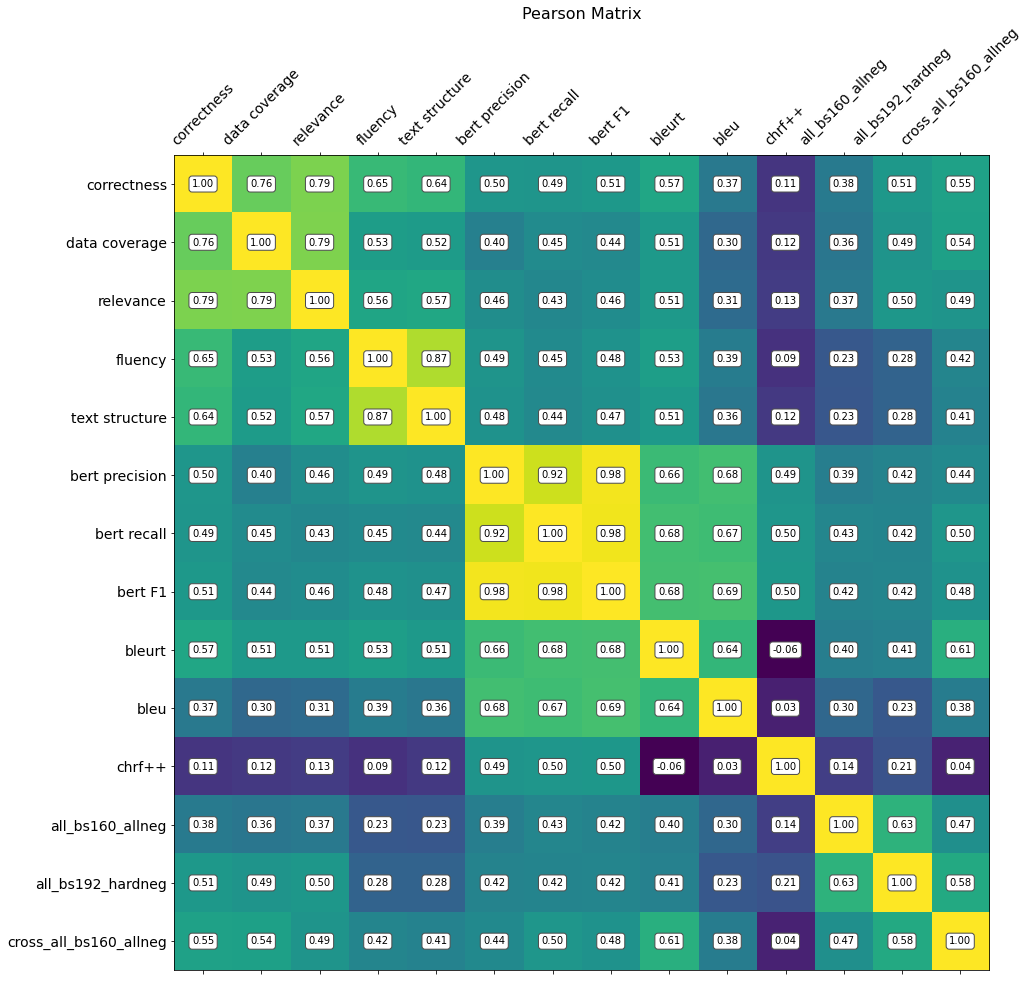

In [22]:
f = plt.figure(figsize=(19, 15))
ax = plt.axes()
ax.matshow(correlations)
for (i, j), z in np.ndenumerate(correlations):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.xticks(range(len(ticks)), ticks, fontsize=14, rotation=45, ha='right', rotation_mode='anchor')
plt.yticks(range(len(ticks)), ticks, fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Pearson Matrix', fontsize=16);

Text(0, 0.5, 'correctness')

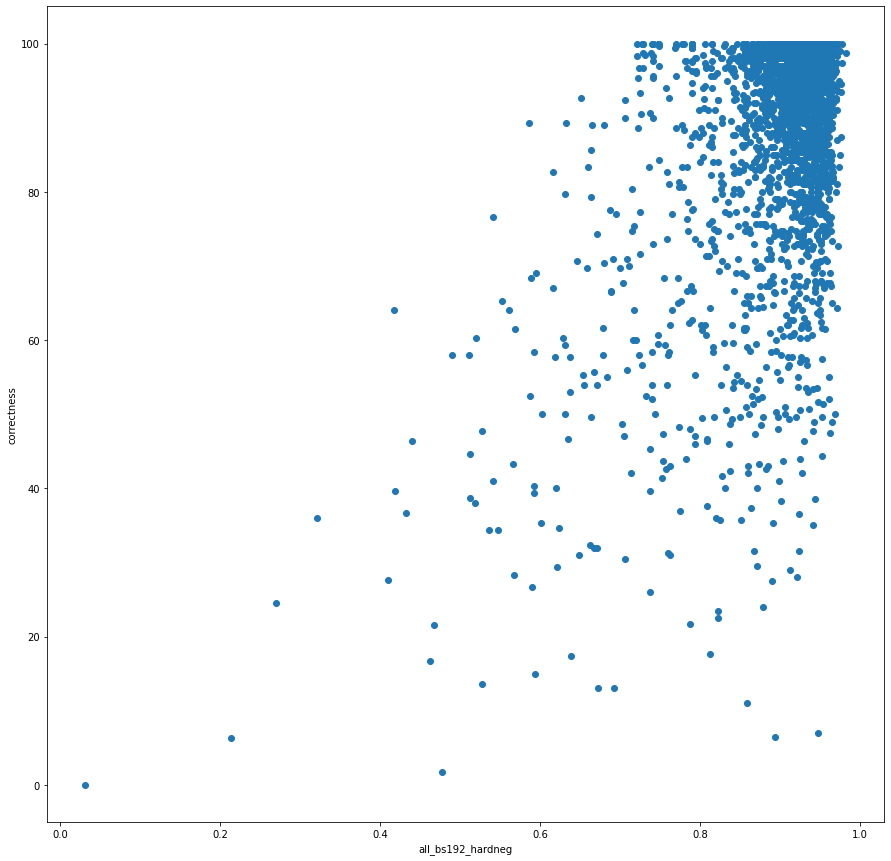

In [16]:
f = plt.figure(figsize=(15, 15))
ax = plt.axes()
ax.scatter(data_2020["all_bs192_hardneg"], data_2020["correctness"])
ax.set_xlabel("all_bs192_hardneg")
ax.set_ylabel("correctness")

In [17]:
data_2020.keys()

dict_keys(['correctness', 'data coverage', 'relevance', 'fluency', 'text structure', 'bert precision', 'bert recall', 'bert F1', 'bleurt', 'bleu', 'chrf++', 'all_bs160_allneg', 'all_bs192_hardneg', 'cross_all_bs160_allneg'])

Text(0, 0.5, 'correctness')

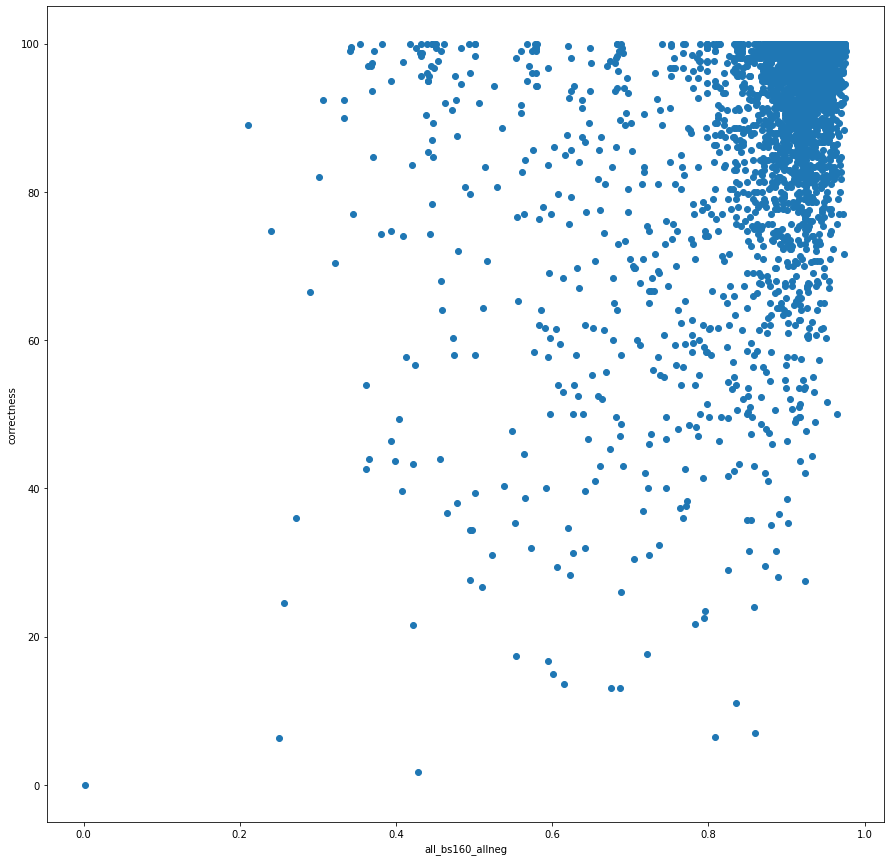

In [18]:
f = plt.figure(figsize=(15, 15))
ax = plt.axes()
ax.scatter(data_2020["all_bs160_allneg"], data_2020["correctness"])
ax.set_xlabel("all_bs160_allneg")
ax.set_ylabel("correctness")

Text(0, 0.5, 'correctness')

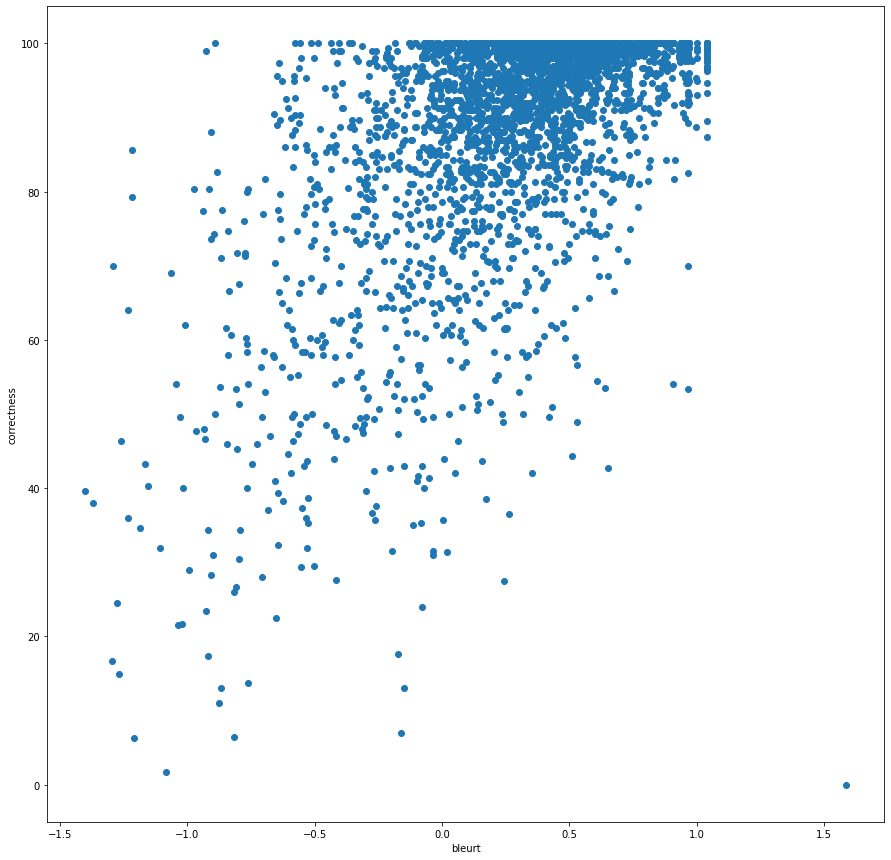

In [19]:
f = plt.figure(figsize=(15, 15))
ax = plt.axes()
ax.scatter(data_2020["bleurt"], data_2020["correctness"])
ax.set_xlabel("bleurt")
ax.set_ylabel("correctness")